# Neal's Funnel Target Practice

In [31]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [32]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [33]:
d = 1000
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [34]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

DynamicPPL.Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.0111148965017045, 0.9851691671285447, -1.1111746028847782, 1.0031028322007052, 2.09254014469917, -1.600592411056759, 1.4030016574407795, -1.174184135812221, -2.189283901328225, -1.6250702438509705, -0.36896963396311067, -0.34618249027317605, 0.556807074788708, 1.6040226062045997, 0.9504964528118238, 0.8638184368591666, -1.02336587726038, 0.46333920396815736, -1.7212601812489463, -0.1728272470420242, 2.3168957028673045, -2.506787005407861, 0.155446630276741, 0.16966393114907197, -0.6995897787634755, 0.5405449572562886, 0.8798635349364927, 3.2745879475148634, -1.1003143238005402, -1.9028175061617392, 1.5996013735445613, -0.016885201356868662, 0.4677703004729242, 1.9340386585026161, -1.4669085371671868, -0.25991500405705736, -1.1260471244722865, 0.38068359315496897, 0.5

## MCHMC

In [35]:
funnel_target = NealFunnelTarget(funnel_model; d=d, compute_MAP=false)
funnel_target.d = d
eps = 2.95
funnel_spl = MCHMC(eps, eps*57; init_eps=0.5, varE_wanted=1.0^-4, sigma=ones(d));

In [36]:
funnel_samples_mchmc = Sample(funnel_spl, funnel_target, 20_000;
                        dialog=true);

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅


In [37]:
theta_mchmc = [sample[1] for sample in funnel_samples_mchmc]
x10_mchmc = [sample[10+1] for sample in funnel_samples_mchmc];

In [38]:
energy_mchmc = [sample[end-1] for sample in funnel_samples_mchmc]

20001-element Vector{Float64}:
     0.0
     8.82533182555153
    19.291615457851776
    18.344255147964986
    11.957733468903143
    15.444026453829792
    47.22979028293253
    78.44688598072707
   269.6344995728216
  -102.41381573127728
  2151.857536778143
  1624.8289906223172
   166.43633734399327
     ⋮
 27673.835990692605
  1194.9335070826737
  -587.0945732637575
  3119.511567448485
 19406.957980927902
  6167.118528655645
  6849.339663011841
  4160.482263366754
  -155.18699253276122
  1889.0002598621763
 -1368.2403046729785
   941.0291300196434

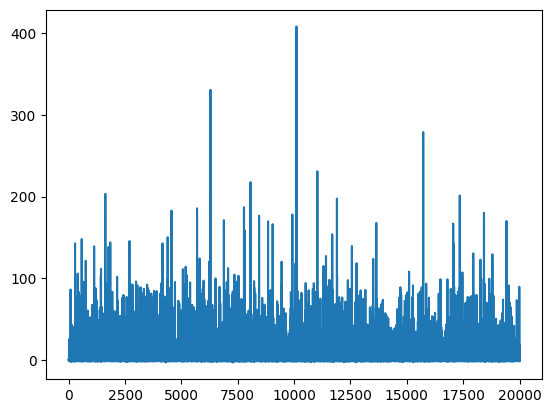

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f82e5fe6ee0>

In [39]:
plot(energy_mchmc/d)

In [40]:
std(energy_mchmc)^2/d

245818.77206090803

In [41]:
using MCMCDiagnosticTools

In [ ]:
_samples = zeros(length(funnel_samples_mchmc), length(funnel_samples_mchmc[1]), 1)
_samples[:, :, 1] = mapreduce(permutedims, vcat, funnel_samples_mchmc)
_samples = permutedims(_samples, (1,3,2))
ess, rhat = MCMCDiagnosticTools.ess_rhat(_samples)

In [ ]:
_ess = median(ess)

In [ ]:
_rhat = median(rhat)

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## NUTS

In [16]:
funnel_samples_hmc = sample(funnel_model, NUTS(10, 0.95), 10_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.2


LoadError: InterruptException:

In [17]:
theta_hmc = [funnel_samples_hmc.value.data[i, 1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]]
x10_hmc = [funnel_samples_hmc.value.data[i, 10+1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]];

LoadError: UndefVarError: `funnel_samples_hmc` not defined

In [18]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("NUTS - Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

LoadError: UndefVarError: `x10_hmc` not defined

In [19]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Comparison - Neal's Funnel", fontsize=16)
fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4,2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

LoadError: UndefVarError: `x10_hmc` not defined